In [176]:
#!/usr/bin/python

import sys
import pickle
sys.path.append("../tools/")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from time import time
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

## Task 1: Feature Selection

In [177]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [178]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ["poi", "salary", "bonus",'from_poi_to_this_person', 'from_this_person_to_poi',
                 'deferral_payments', 'total_payments', 'loan_advances', 'restricted_stock_deferred',
                 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options',
                 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees']
features_list = ["poi", "salary", "bonus", 'from_poi_to_this_person', 'from_this_person_to_poi',
                 'deferral_payments', 'total_payments', 'loan_advances', #'restricted_stock_deferred',
                 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options',
                 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees']

In [179]:
print "Number of persons within the dataset:", len(data_dict)

Number of persons within the dataset: 146


In [180]:
# print names of all 146 individuals:
print data_dict.keys()

['METTS MARK', 'BAXTER JOHN C', 'ELLIOTT STEVEN', 'CORDES WILLIAM R', 'HANNON KEVIN P', 'MORDAUNT KRISTINA M', 'MEYER ROCKFORD G', 'MCMAHON JEFFREY', 'HORTON STANLEY C', 'PIPER GREGORY F', 'HUMPHREY GENE E', 'UMANOFF ADAM S', 'BLACHMAN JEREMY M', 'SUNDE MARTIN', 'GIBBS DANA R', 'LOWRY CHARLES P', 'COLWELL WESLEY', 'MULLER MARK S', 'JACKSON CHARLENE R', 'WESTFAHL RICHARD K', 'WALTERS GARETH W', 'WALLS JR ROBERT H', 'KITCHEN LOUISE', 'CHAN RONNIE', 'BELFER ROBERT', 'SHANKMAN JEFFREY A', 'WODRASKA JOHN', 'BERGSIEKER RICHARD P', 'URQUHART JOHN A', 'BIBI PHILIPPE A', 'RIEKER PAULA H', 'WHALEY DAVID A', 'BECK SALLY W', 'HAUG DAVID L', 'ECHOLS JOHN B', 'MENDELSOHN JOHN', 'HICKERSON GARY J', 'CLINE KENNETH W', 'LEWIS RICHARD', 'HAYES ROBERT E', 'MCCARTY DANNY J', 'KOPPER MICHAEL J', 'LEFF DANIEL P', 'LAVORATO JOHN J', 'BERBERIAN DAVID', 'DETMERING TIMOTHY J', 'WAKEHAM JOHN', 'POWERS WILLIAM', 'GOLD JOSEPH', 'BANNANTINE JAMES M', 'DUNCAN JOHN H', 'SHAPIRO RICHARD S', 'SHERRIFF JOHN R', 'SHELBY 

In [181]:
# print entries of the first person:
print data_dict['ALLEN PHILLIP K']

{'salary': 201955, 'to_messages': 2902, 'deferral_payments': 2869717, 'total_payments': 4484442, 'exercised_stock_options': 1729541, 'bonus': 4175000, 'restricted_stock': 126027, 'shared_receipt_with_poi': 1407, 'restricted_stock_deferred': -126027, 'total_stock_value': 1729541, 'expenses': 13868, 'loan_advances': 'NaN', 'from_messages': 2195, 'other': 152, 'from_this_person_to_poi': 65, 'poi': False, 'director_fees': 'NaN', 'deferred_income': -3081055, 'long_term_incentive': 304805, 'email_address': 'phillip.allen@enron.com', 'from_poi_to_this_person': 47}


##  Data Exploration

In [182]:
df = pd.DataFrame(data_dict)
df = df.T
df = df.replace('NaN', 0)
df.dtypes

bonus                         int64
deferral_payments             int64
deferred_income               int64
director_fees                 int64
email_address                object
exercised_stock_options       int64
expenses                      int64
from_messages                 int64
from_poi_to_this_person       int64
from_this_person_to_poi       int64
loan_advances                 int64
long_term_incentive           int64
other                         int64
poi                            bool
restricted_stock              int64
restricted_stock_deferred     int64
salary                        int64
shared_receipt_with_poi       int64
to_messages                   int64
total_payments                int64
total_stock_value             int64
dtype: object

In [183]:
#cols = df.columns.drop(['email_address','poi'])
#df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

In [184]:
df.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000,2869717,-3081055,0,phillip.allen@enron.com,1729541,13868,2195,47,65,...,304805,152,False,126027,-126027,201955,1407,2902,4484442,1729541
BADUM JAMES P,0,178980,0,0,0,257817,3486,0,0,0,...,0,0,False,0,0,0,0,0,182466,257817
BANNANTINE JAMES M,0,0,-5104,0,james.bannantine@enron.com,4046157,56301,29,39,0,...,0,864523,False,1757552,-560222,477,465,566,916197,5243487
BAXTER JOHN C,1200000,1295738,-1386055,0,0,6680544,11200,0,0,0,...,1586055,2660303,False,3942714,0,267102,0,0,5634343,10623258
BAY FRANKLIN R,400000,260455,-201641,0,frank.bay@enron.com,0,129142,0,0,0,...,0,69,False,145796,-82782,239671,0,0,827696,63014


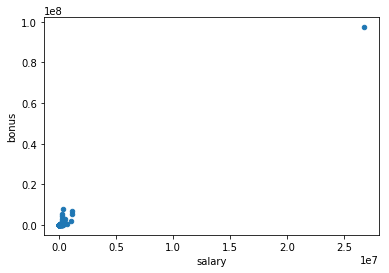

In [185]:
df.plot('salary','bonus',kind = 'scatter')

In [186]:
df[df['bonus']==df['bonus'].max()]

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
TOTAL,97343619,32083396,-27992891,1398517,0,311764000,5235198,0,0,0,...,48521928,42667589,False,130322299,-7576788,26704229,0,0,309886585,434509511


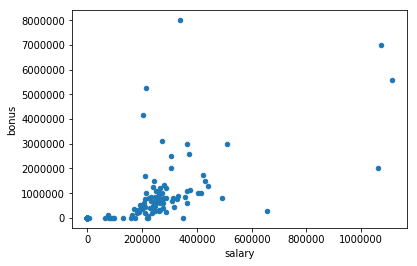

In [187]:
### Task 2: Remove outliers
# the total entry is obviously an outlier, which will be droped from the dataframe
df = df.drop(['TOTAL'])
data_dict.pop('TOTAL', 0)
df.plot('salary','bonus',kind = 'scatter')

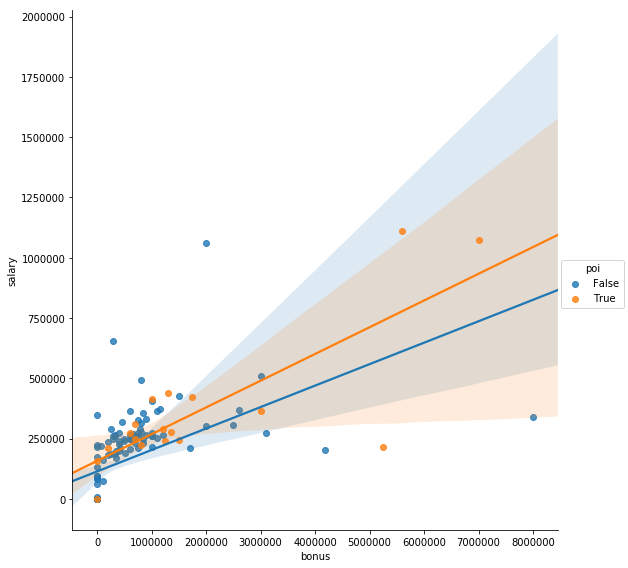

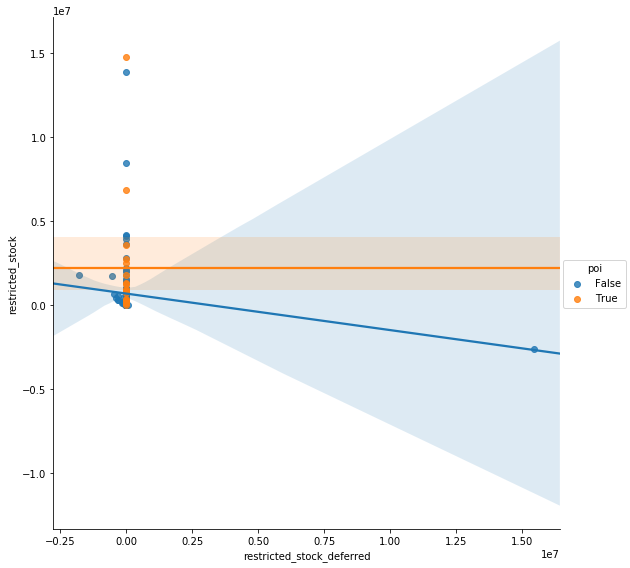

In [188]:
#sns.pairplot(df, vars=['salary', 'total_payments'], hue= 'poi', size = 5)
sns.lmplot(data = df, x = 'bonus', y = 'salary', hue = 'poi', size = 8)
sns.lmplot(data = df, x = 'restricted_stock_deferred', y = 'restricted_stock', hue = 'poi', size = 8)

In [189]:
# looking at the graph above, I think the feature "restricted_stock_deferred" is irrelevant to identify poi, and will decrease accuracy.
# Indeed, by removing this feature I increased the score from 0.66 to 0.91.
df[df['restricted_stock_deferred']==df['restricted_stock_deferred'].max()]

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
BHATNAGAR SANJAY,0,0,0,137864,sanjay.bhatnagar@enron.com,2604490,0,29,0,1,...,0,137864,False,-2604490,15456290,0,463,523,15456290,0


## Task 3: Create new feature(s)

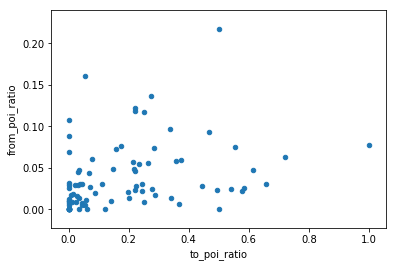

In [196]:
### Task 3: Create new feature(s)

#Note that I only create some new features fot the sake of the project submission. 
#At the end I will use a decision tree classifier, so scaling does not influence results.

df['from_poi_ratio'] = df['from_poi_to_this_person'] / df['to_messages']
df['to_poi_ratio'] = df['from_this_person_to_poi'] / df['from_messages']
df.plot('to_poi_ratio','from_poi_ratio',kind = 'scatter')


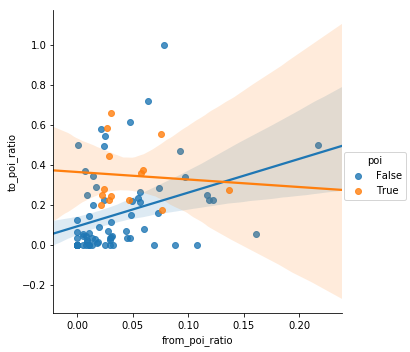

In [199]:
sns.lmplot(data = df, x = 'from_poi_ratio', y = 'to_poi_ratio', hue = 'poi', size = 5)

In [192]:
### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset for local testing

data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
labels_df = df['poi']
features_df = df[features_list].drop(['poi'], axis = 1)


## Task 4: Try a varity of classifiers

In [193]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.

features_train, features_test, labels_train, labels_test = \
    train_test_split(features_df, labels_df, test_size=0.3, random_state=42)

from sklearn.svm import SVC
clf = SVC()
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
pred = clf.predict(features_test)
print "accuracy score SVC:","%.2f" % round(score,2)

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
pred = clf.predict(features_test)
print "accuracy score DT:","%.2f" % round(score,2)

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
pred = clf.predict(features_test)
print "accuracy score RF:","%.2f" % round(score,2)

# The Randomforest perform quite good, so I will try to tune this one.


accuracy score SVC: 0.91
accuracy score DT: 0.86
accuracy score RF: 0.84


In [ ]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!

features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)